##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [CycleGAN](./cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev), check out the [Fast style transfer for arbitrary styles](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) tutorial that uses an [arbitrary image stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2). For an example of style transfer with [TensorFlow Lite](https://www.tensorflow.org/lite), refer to [Artistic style transfer with TensorFlow Lite](https://www.tensorflow.org/lite/examples/style_transfer/overview).

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now, what would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


In [2]:
pip install tensorflow


  Using cached tensorflow-2.16.1-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp312-cp312-win_amd64.whl.metadata (5.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.7-py2.py3-none-any.whl.metadata (849 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.10.0-cp312-cp312-win_amd64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 k

In [1]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
nvcc --version


NameError: name 'nvcc' is not defined

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### Import and configure modules

In [9]:


import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [4]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

NameError: name 'tf' is not defined

In [13]:
content_path ='architecture/04_Monasterio_de_Palazuelos_absides_exterior_ni.jpg'
style_path ='Vincent_van_Gogh/Vincent_van_Gogh_871.jpg'

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [10]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [11]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

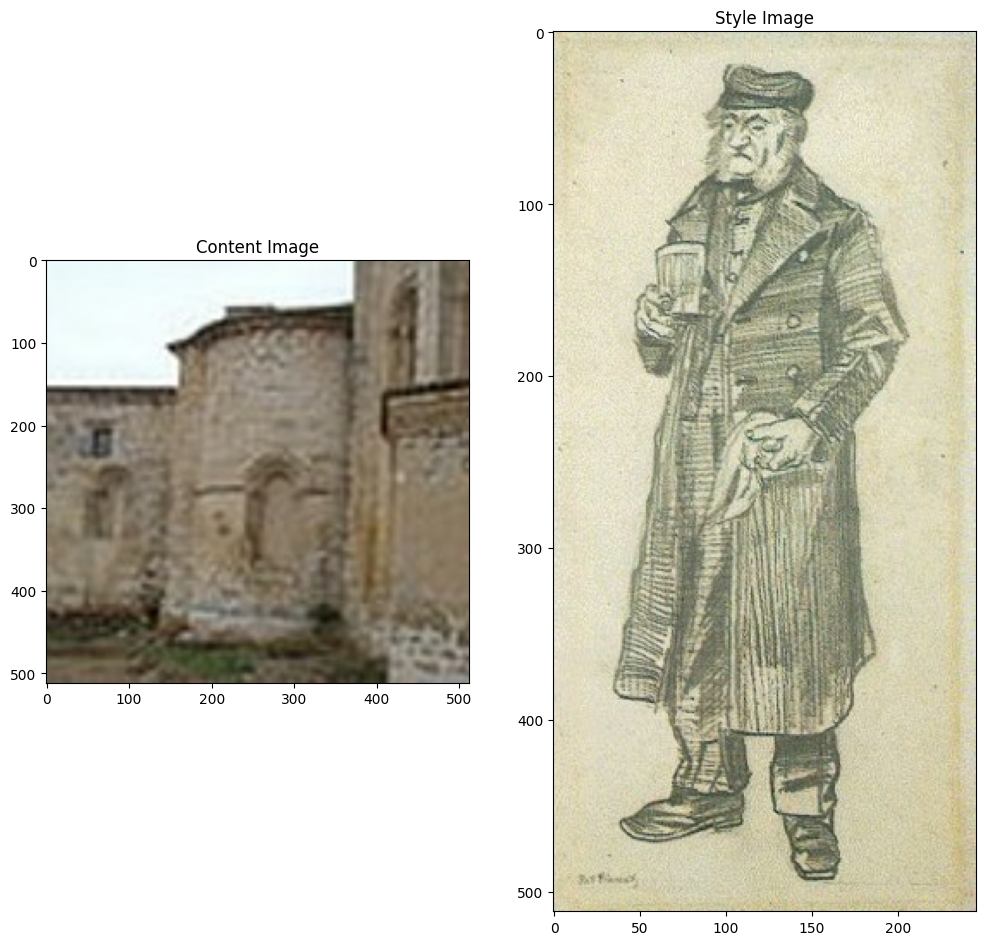

In [14]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) does this:

In [5]:
pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [15]:
model_url = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'

# Download the model and save it locally
model_path = tf.keras.utils.get_file('arbitrary_image_stylization_model', model_url + '?tf-hub-format=compressed')

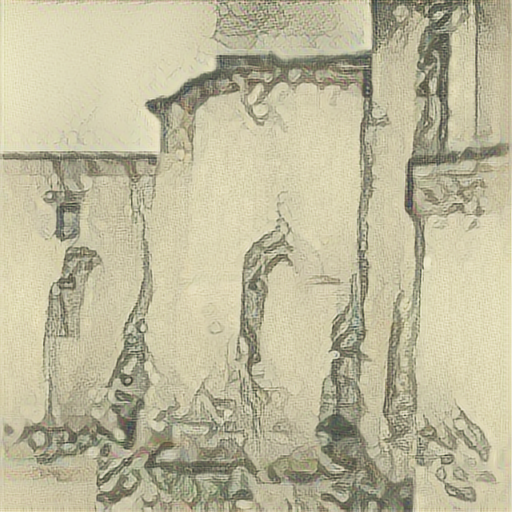

In [16]:

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) and test run it on our image to ensure it's used correctly:

In [17]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [18]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('monastery', 0.9333323),
 ('castle', 0.040205013),
 ('palace', 0.0062097893),
 ('prison', 0.0052695875),
 ('triumphal_arch', 0.0032272236)]

Now load a `VGG19` without the classification head, and list the layer names

In [19]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [20]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [21]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [22]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 246, 64)
  min:  0.0
  max:  766.022
  mean:  33.215996

block2_conv1
  shape:  (1, 256, 123, 128)
  min:  0.0
  max:  2793.7795
  mean:  180.3933

block3_conv1
  shape:  (1, 128, 61, 256)
  min:  0.0
  max:  8957.31
  mean:  135.86794

block4_conv1
  shape:  (1, 64, 30, 512)
  min:  0.0
  max:  12556.667
  mean:  575.36017

block5_conv1
  shape:  (1, 32, 15, 512)
  min:  0.0
  max:  2235.0254
  mean:  42.145683



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [23]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [44]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [25]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.004781934
    max:  29355.354
    mean:  133.32834

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  44787.2
    mean:  3767.8496

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  117200.41
    mean:  3962.2886

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1728070.2
    mean:  57885.01

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  50190.15
    mean:  374.71027

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  814.8502
    mean:  6.775712


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [26]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [27]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [28]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [29]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [30]:
style_weight=1e-2
content_weight=1e4

In [31]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [32]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

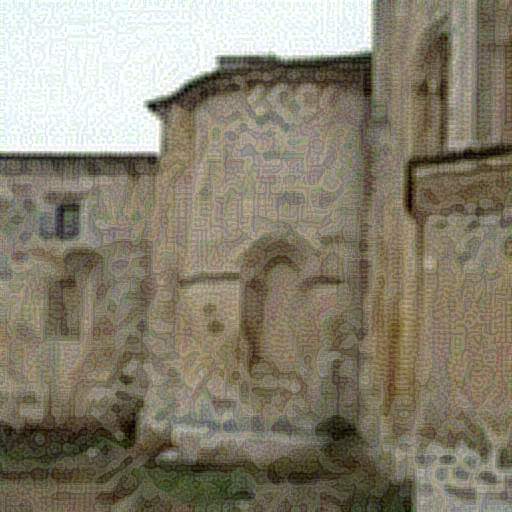

In [33]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

In [54]:
pip install json


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [56]:
import time
import json
start = time.time()

epochs = 1
steps_per_epoch = 2


def save_model_with_config(model, model_file_name, style_layers, content_layers):
    model.save(model_file_name, save_format='h5')
    model_config = {'style_layers': style_layers, 'content_layers': content_layers}
    with open('model_config.json', 'w') as f:
        json.dump(model_config, f)


step = 0
for epoch in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    
    # Save model at the end of each epoch with a different file name
model_file_name = 'model_epoch.h5'
save_model_with_config(extractor, model_file_name, style_layers, content_layers)

  # Display training progress
display.clear_output(wait=True)
display.display(tensor_to_image(image))
print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

..

ValueError: Unable to synchronously create dataset (name already exists)

In [56]:
import tensorflow as tf

extractor = StyleContentModel(style_layers, content_layers)

# Define the directory where you want to save the model
saved_model_path = "./saved_model80epoches"

# Save the model
tf.saved_model.save(extractor, saved_model_path)

print("Model saved successfully at:", saved_model_path)

INFO:tensorflow:Assets written to: ./saved_model80epoches\assets


INFO:tensorflow:Assets written to: ./saved_model80epoches\assets


Model saved successfully at: ./saved_model80epoches


In [15]:
print(dir(loaded_model))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_copy_trackable_to_cpu', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_inbound_nodes', '_lookup_dependency', '_loss_ids', '_losses', '_maybe_initialize_trackable', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_outbound_nodes', '_preload_simple_restoration', '_restore_from_tensors', '_self_name_based_restores', '_self_saveable_obj

In [14]:
import tensorflow as tf
loaded_mdoel = tf.saved_model.load(
    'saved_model80epoches', tags=None, options=None
)

In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import tensorflow_hub as hub


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, trainable=None, dtype=None):  # Add trainable=None
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}



# Register the custom layer class
tf.keras.utils.get_custom_objects()['StyleContentModel'] = StyleContentModel

# Load the model architecture (do not load the weights yet)
hub_model = tf.keras.models.load_model('model_epoch.h5', compile=False)

# Load content and style images
content_image = mpimg.imread('Vincent_van_Gogh/Vincent Van Gogh - The Starry Night.jpg')
style_image = mpimg.imread('Vincent_van_Gogh/Vincent_van_Gogh_8.jpg')
style_image = tf.image.resize(style_image, (256, 256))

# Preprocess images
content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.

# Stylize image
outputs = hub_model(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs['stylized_image']

# Display or save the stylized image
plt.imshow(stylized_image[0])
plt.axis('off')
plt.show()


TypeError: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.StyleContentModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of StyleContentModel from its config.

Received config={'trainable': True, 'dtype': 'float32'}

Error encountered during deserialization: StyleContentModel.__init__() missing 2 required positional arguments: 'style_layers' and 'content_layers'

**RUN MODEL HERE**

In [2]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [1]:
import cv2
import os
import tensorflow as tf
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')


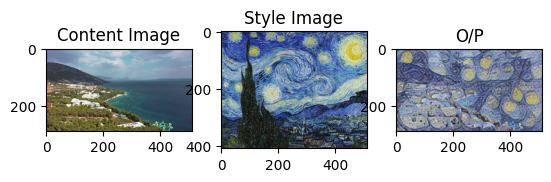

In [10]:

content_image = load_img("temporary_video_frames/frame_2.jpg")
style_image = load_img("Vincent_van_Gogh/Vincent Van Gogh - The Starry Night.jpg")

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

plt.subplot(1, 3, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
imshow(stylized_image, 'O/P')

# tensor_to_image(stylized_image)

In [2]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [2]:
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [61]:
pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
def convert_to_720p(input_file, output_file):
    cap = cv2.VideoCapture(input_file)

    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    target_width = 1280
    target_height = 720

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 30, (target_width, target_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            resized_frame = cv2.resize(frame, (target_width, target_height))
            out.write(resized_frame)
            cv2.imshow('Frame', resized_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

input_file = 'testvideo.mp4'
output_file = 'output_video_720p.mp4'

convert_to_720p(input_file, output_file)

In [3]:
video_path = "testvideo.mp4"
output_folder = "temporary_video_frames"
stylized_output_folder = "stylized_frames_op"
style_img_path = "Vincent_van_Gogh/Vincent_van_Gogh_153.jpg"

def load_img(path_to_img):
    max_dim = 2048
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
user_defined_fps = 24

os.makedirs(output_folder, exist_ok=True)
os.makedirs(stylized_output_folder, exist_ok=True)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('output_video.mp4', fourcc, user_defined_fps, (int(cap.get(3)), int(cap.get(4))))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1

    if frame_count % int(fps / user_defined_fps) == 0:
        cv2.imwrite(os.path.join(output_folder, f"frame_{frame_count}.jpg"), frame)
        content_image = load_img(os.path.join(output_folder, f"frame_{frame_count}.jpg"))
        style_image = load_img(style_img_path)  # Change path to your style image
        
        # Perform stylization
        stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
        
        # Display content and stylized images for debugging
        # imshow(content_image[0], title='Content Image')
        # imshow(stylized_image, title='Stylized Image')
        
        # Convert to numpy array and save
        stylized_image = tf.image.convert_image_dtype(stylized_image, tf.uint8)
        stylized_image_np = tf.image.encode_jpeg(tf.cast(stylized_image[0] * 255, tf.uint8))
        with open(os.path.join(stylized_output_folder, f"stylized_frame_{frame_count}.jpg"), 'wb') as f:
            f.write(stylized_image_np.numpy())
        
        output_video.write(cv2.cvtColor(stylized_image[0].numpy(), cv2.COLOR_RGB2BGR))

    # Print progress bar
    progress = frame_count / total_frames
    bar_length = 40
    progress_bar = int(bar_length * progress)
    percent = round(progress * 100, 2)
    bar = '=' * progress_bar + '.' * (bar_length - progress_bar)
    print(f'\rProgress: [{bar}] {percent}% Complete', end='', flush=True)

cap.release()
output_video.release()

# Print completion message
print("\nVideo processing completed.")

Progress: [........................................] 0.54% Complete

KeyboardInterrupt: 

In [4]:
import cv2
import os


# Path to directory containing stylized images
stylized_images_dir = "D:/TE6miniprojectmodels/thirdprogram/stylized_frames_op"

# Get list of stylized image files sorted by creation time
image_files = sorted(
    [os.path.join(stylized_images_dir, file) for file in os.listdir(stylized_images_dir)],
    key=lambda x: os.path.getmtime(x)
)

# Read the first image to get dimensions
first_image = cv2.imread(image_files[0])
height, width, _ = first_image.shape

# Define output video settings
output_video_path = "output_stylized_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_video_path, fourcc, 30, (width, height))

# Write stylized images to video
for image_file in image_files:
    image = cv2.imread(image_file)
    output_video.write(image)

# Release video writer
output_video.release()

print(f"Video saved as: {output_video_path}")

Video saved as: output_stylized_video.mp4


In [7]:
import cv2

# Open the video file
video_capture = cv2.VideoCapture('output_stylized_video.mp4')

# Create a VideoWriter object to save the processed video
output_video = cv2.VideoWriter('output_video_sharpened.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (int(video_capture.get(3)), int(video_capture.get(4))))

# Process each frame in the video
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    
    # Apply Laplacian filter for sharpening
    sharpened_frame = cv2.Laplacian(frame, cv2.CV_64F)
    sharpened_frame = cv2.convertScaleAbs(sharpened_frame)

    # Write the sharpened frame to the output video
    output_video.write(sharpened_frame)

# Release video capture and writer objects
video_capture.release()
output_video.release()


In [17]:
print(dir(loaded_model))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_trackable_child', '_add_variable_with_custom_getter', '_checkpoint_dependencies', '_copy_trackable_to_cpu', '_deferred_dependencies', '_delete_tracking', '_deserialization_dependencies', '_deserialize_from_proto', '_export_to_saved_model_graph', '_gather_saveables_for_checkpoint', '_handle_deferred_dependencies', '_inbound_nodes', '_lookup_dependency', '_loss_ids', '_losses', '_maybe_initialize_trackable', '_name_based_attribute_restore', '_name_based_restores', '_no_dependency', '_object_identifier', '_outbound_nodes', '_preload_simple_restoration', '_restore_from_tensors', '_self_name_based_restores', '_self_saveable_obj

In [12]:
print("Available Signatures:", loaded_model.signatures.keys())

Available Signatures: KeysView(_SignatureMap({}))


## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [38]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

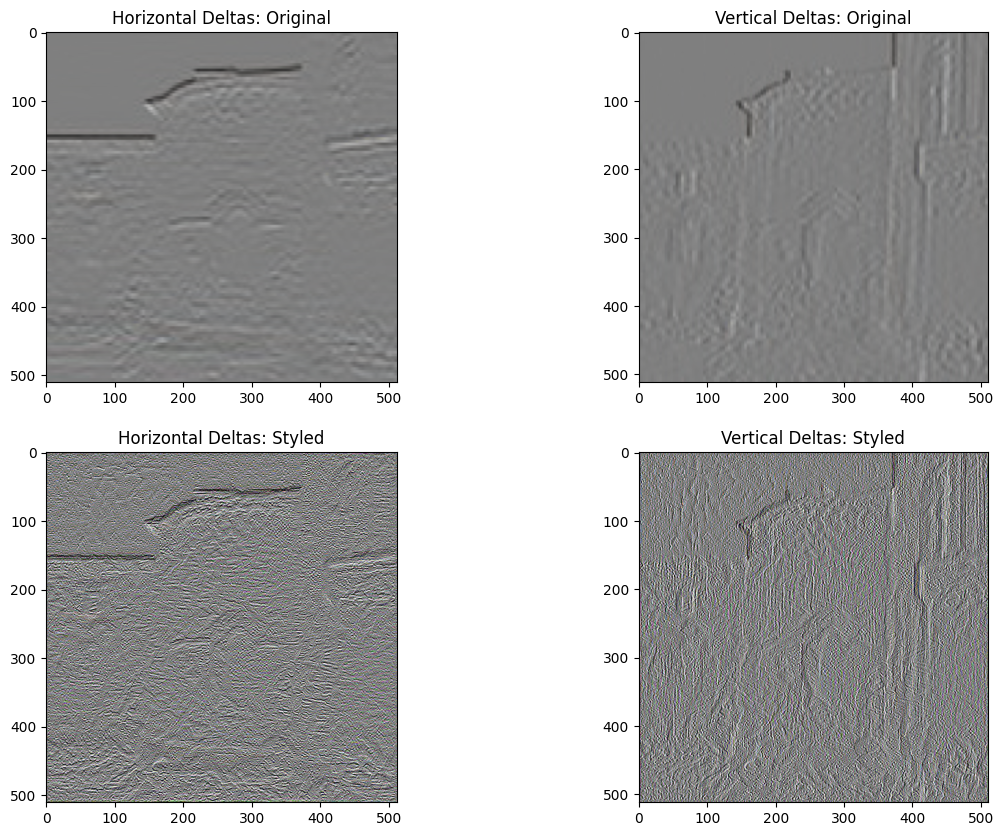

In [39]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example:

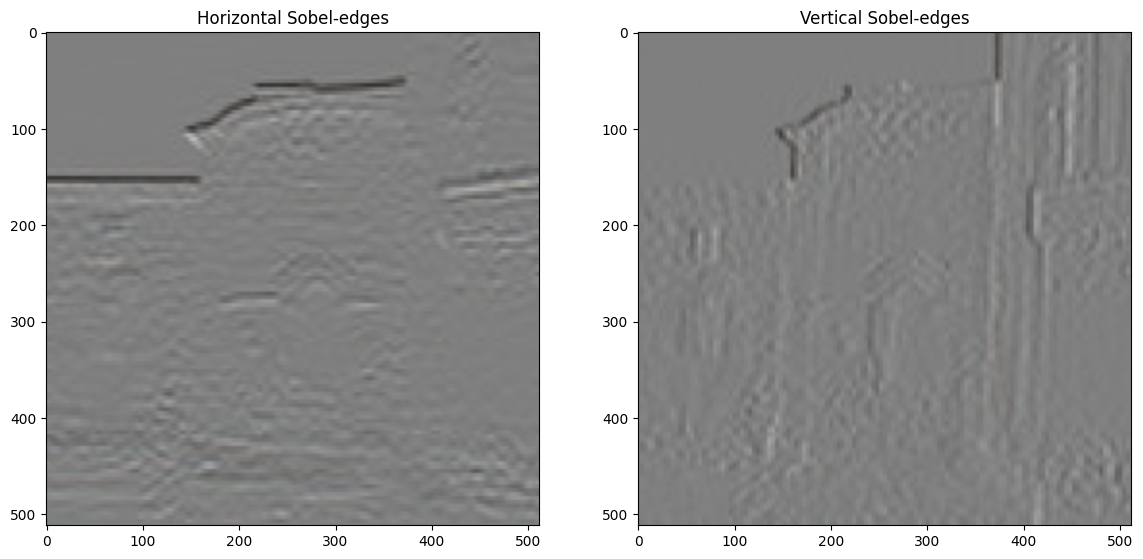

In [40]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [41]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [42]:
total_variation_loss(image).numpy()

122546.055

That demonstrated what it does. But there's no need to implement it yourself, TensorFlow includes a standard implementation:

In [43]:
tf.image.total_variation(image).numpy()

array([122546.055], dtype=float32)

In [46]:
#store the trained model
    saved_model_path = "./saved_model_epoch_20"  # Path to save the model for this epoch
    tf.saved_model.save(hub_model, saved_model_path)

IndentationError: unexpected indent (152573095.py, line 2)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [34]:
total_variation_weight=30

Now include it in the `train_step` function:

In [35]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [36]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

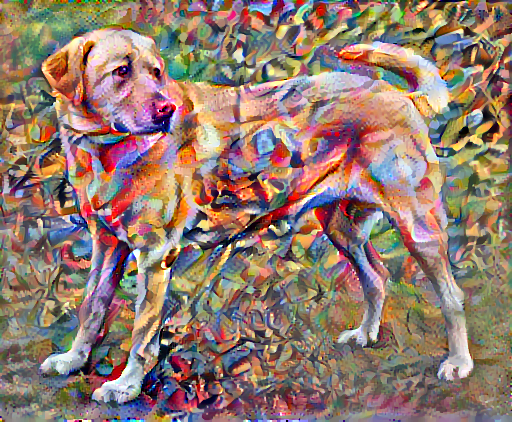

Train step: 1000
Total time: 84.6


In [37]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [38]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

## Learn more

This tutorial demonstrates the original style-transfer algorithm. For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the arbitrary image style transfer model from [TensorFlow Hub](https://tfhub.dev).